In [14]:
from ML.EFPs.data_loaders import load_data_qg_tagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import joblib
import utilities.utilities as utilities

#### Loading the Dataset

In [10]:
root_data_folder = "../../../Data"
X_train, y_train = load_data_qg_tagging(
    quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy"
)
X_val, y_val = load_data_qg_tagging(
    quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy"
)

#### Creating the Decision Tree

###### Grid Search to find the best hyperparameters

In [11]:
# First we perform a grid search to look for the best hiperparamers for the model
model = DecisionTreeClassifier(criterion="entropy")

# first search - Best result: max_depth=10 min_samples_split=100
# second search - Best result: max_depth=10 min_samples_split=200
# third search - Best result: max_depth=9 min_samples_split=200
# fourth search - Best result: max_depth=9 min_samples_split=250
params_for_search = {
    # 1. [10, 20, 30, 40],
    # 2. [5, 10, 15],
    # 3. [8, 9, 10, 11, 12]
    # 4. [9]
    "max_depth": [9],
    # 1. [10, 20, 30, 40, 50, 100],
    # 2. [100, 125, 150, 200],
    # 3. [200]
    # 4. [200, 250, 300]
    "min_samples_split": [200, 250, 300]
}

grid_search = GridSearchCV(model, params_for_search, return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [12]:
pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,params,mean_test_score
2,"{'max_depth': 9, 'min_samples_split': 300}",0.786287
1,"{'max_depth': 9, 'min_samples_split': 250}",0.786283
0,"{'max_depth': 9, 'min_samples_split': 200}",0.786187


###### Trainning the best tree (not needed, but good to train over the entire dataset and check it in the validation set)

In [12]:
# trainning a tree with max_depth equal to 9 and min_samples_split equal to 250
tree = DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_split=250)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=250)

In [13]:
tree.feature_importances_

array([8.51976244e-01, 1.11073881e-01, 1.74483862e-03, 7.71193199e-03,
       7.51722481e-03, 3.93850694e-03, 9.82797692e-04, 1.22429432e-03,
       3.90146638e-04, 5.64070176e-04, 6.71958858e-04, 1.15844497e-04,
       3.84377015e-03, 3.28897594e-04, 7.52728634e-04, 1.14596668e-04,
       2.09886864e-03, 1.95222837e-04, 0.00000000e+00, 1.75135877e-04,
       1.65308855e-04, 2.05327736e-04, 0.00000000e+00, 0.00000000e+00,
       2.55954284e-04, 3.49836922e-04, 0.00000000e+00, 4.16924005e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.91566537e-04, 9.50535098e-05, 5.16377037e-04, 2.02915114e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08500714e-04,
       0.00000000e+00, 4.28873833e-05, 0.00000000e+00, 1.09763764e-04,
       7.83845168e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.74023935e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [17]:
np.argsort(tree.feature_importances_)[::-1]

array([ 0,  1,  3,  4,  5, 12, 16,  2, 48,  7,  6, 14, 10,  9, 34, 27,  8,
       25, 13, 32, 24, 21, 35, 17, 19, 20, 11, 15, 43, 39, 33, 44, 41, 18,
       53, 22, 40, 51, 50, 49, 47, 46, 45, 42, 38, 23, 37, 36, 31, 30, 29,
       28, 52, 26])

#### Some quick checks

In [7]:
y_val_predict = tree.predict(X_val)
utilities.display_metrics(y_val, y_val_predict)

Recall: 0.7678
Precision: 0.7919
Confusion Matrix:
[[18210  4390]
 [ 5053 16709]]


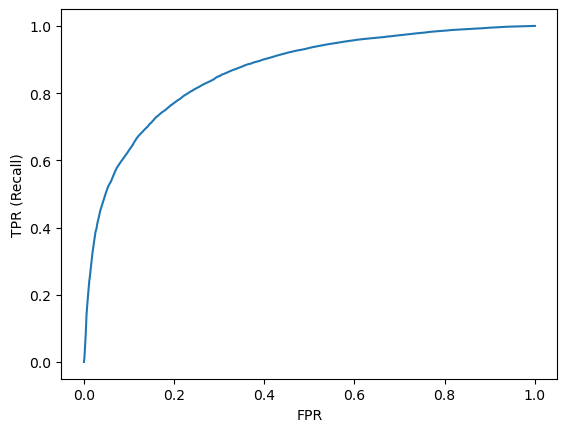

AUC: 0.8657


In [18]:
# roc curve on the validation set
y_score = tree.predict_proba(X_val)
utilities.display_roc_curve(y_val, y_score[:, 1])

#### Saving Model

In [19]:
with open("QuarkGluon_Tagging_DT.joblib", "wb") as fo:
    joblib.dump(tree, fo)